<a href="https://colab.research.google.com/github/GuoyaoShen/DiatomDL/blob/main/main_v_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

v1.1: finish the routine for a 6-layer dense net

This script works as a main script of v1.0 for testing

# Mount Drive

In [106]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loading

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms

## Create Dataset

In [108]:
path_dataset = '/content/drive/My Drive/BU Class/Research/BioDL_Project/data/diatom_219.npz'

data = np.load(path_dataset)
print(data['param'].shape)
print(data['R'].shape)
print(data['T'].shape)



param = data['param']
spectra_R = data['R'][...,1]
spectra_T = data['T'][...,1]

# param_inverse = 1/param
# param = np.concatenate((param,param_inverse), axis=1)

print(param.shape)
print(spectra_R.shape)
print(spectra_T.shape)
# print(param[0])
# print(spectra_R)

(219, 11)
(219, 1001, 2)
(219, 1001, 2)
(219, 11)
(219, 1001)
(219, 1001)


In [109]:
tensor_x = torch.Tensor(param) # transform to torch tensor
tensor_y = torch.Tensor(spectra_R)

print(tensor_x.shape)
print(tensor_y.shape)

dataset_ref_train = TensorDataset(tensor_x,tensor_y)

# dataset_ref_train, dataset_ref_test = random_split(dataset_ref, [200, 19], generator=torch.Generator().manual_seed(7))
print(len(dataset_ref_train))
# print(len(dataset_ref_test))

dataloader_ref_train = DataLoader(dataset_ref_train, batch_size=10, shuffle=True)
# dataloader_ref_test = DataLoader(dataset_ref_test, batch_size=10, shuffle=True)
print(len(dataloader_ref_train))
# print(len(dataloader_ref_test))

torch.Size([219, 11])
torch.Size([219, 1001])
219
22


## Create Testset

In [110]:
path_dataset_test = '/content/drive/My Drive/BU Class/Research/BioDL_Project/data/diatom_test.npz'

data_test = np.load(path_dataset_test)

param_test = data_test['param']
spectra_R_test = data_test['R'][...,1]
spectra_T_test = data_test['T'][...,1]

print(param_test.shape)
print(spectra_R_test.shape)
print(spectra_T_test.shape)

(40, 11)
(40, 1001)
(40, 1001)


In [111]:
tensor_x_test = torch.Tensor(param_test) # transform to torch tensor
tensor_y_test = torch.Tensor(spectra_R_test)

print(tensor_x_test.shape)
print(tensor_y_test.shape)

dataset_ref_test = TensorDataset(tensor_x_test,tensor_y_test)

dataloader_ref_test = DataLoader(dataset_ref_test, batch_size=10, shuffle=True)
print(len(dataloader_ref_test))

torch.Size([40, 11])
torch.Size([40, 1001])
4


## Create Mega Dataset

In [112]:
tensor_x_mega = torch.cat((tensor_x, tensor_x_test), 0)
tensor_y_mega = torch.cat((tensor_y, tensor_y_test), 0)

dataset_ref_mega = TensorDataset(tensor_x_mega,tensor_y_mega)
dataloader_ref_mega = DataLoader(dataset_ref_mega, batch_size=10, shuffle=True)

print(len(dataset_ref_mega))

259


# Model

## Model Construct

In [113]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class SquareLayer(nn.Module):
    '''
    This layer works as a function of: y = xAx+(Bx)+C
    '''
    def __init__(self, dim_in, dim_out):
        super(SquareLayer, self).__init__()
        self.linear = nn.Linear(dim_in, dim_out, bias=False)
        self.bilinear = nn.Bilinear(dim_in, dim_in, dim_out)

    def forward(self, x):
        out = self.linear(x) + self.bilinear(x,x)
        return  out


class NetDense(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(NetDense, self).__init__()
        self.ksz1d = 50

        self.fc_encoder = nn.Sequential(
        SquareLayer(dim_in, 100),
        # nn.Linear(dim_in, 100),
        nn.ReLU(True),
        nn.Linear(100, 500),
        nn.ReLU(True),
        nn.Linear(500, 1000),
        nn.ReLU(True),
        nn.Linear(1000, 2000),
        nn.ReLU(True),
        nn.Linear(2000, 4000),
        nn.ReLU(True),
        nn.Linear(4000, 2000),
        nn.ReLU(True),
        nn.Linear(2000, dim_out),
        # nn.ReLU(True),
        # nn.Linear(2500, dim_out+self.ksz1d-1),
        # nn.ReLU(True),
        # nn.Linear(1500, 500),
        # nn.ReLU(True),
        # nn.Linear(1500, 500),
        )

        self.conv = nn.Conv1d(1, 1, kernel_size=self.ksz1d, stride=1)

        # self.conv_decoder = nn.Sequential(
        # pass
        # )

    

    def forward(self, x):
        out = self.fc_encoder(x)
        # # print(out.shape[0])
        # out = out.view(out.shape[0], 1, out.shape[1])
        # # print(out.shape)
        # out = self.conv(out)
        # # print(out.shape)
        # out = out.view(out.shape[0], out.shape[2])

        return out

## Train & Test Function

In [114]:
def train_model(train_dataloader, test_dataloader, optimizer, loss, net, device, NUM_EPOCH=5, scheduler=None, use_logger=False):
    net = net.to(device)
    net.train()

    if scheduler != None:
        print('*** WILL USE SCHEDULER ***')

    for i in range(NUM_EPOCH):
        running_loss = 0.0
        # running_acc = 0.0
        for idx, data in enumerate(train_dataloader):
            X, y = data
            # print(X.shape)
            # print(y.shape)

            X = X.to(device)
            y = y.to(device)

            # if idx==0:
            #     print(X.shape, y.shape)

            y_pred = net(X)

            optimizer.zero_grad()
            loss_train = loss(y_pred, y)
            loss_train.backward()
            optimizer.step()
            running_loss += loss_train.item()

            # if (idx+1)%5==0:
            #     print('EPOCH '+str(i+1)+'/'+str(NUM_EPOCH)+' || '+'STEP '+str(idx+1)+'/'+str(len(train_dataloader))+' || '+'LOSS: '+str(running_loss/(idx+1)))
            #     print('===================================================')
        print('----------------------------------------------------------------------')
        print('*** EPOCH '+str(i+1)+' || AVG LOSS '+str(running_loss/len(train_dataloader)))
        # print('----------------------------------------------------------------------')

        # test model for each epoch
        test_model(test_dataloader, loss, net, device, i, use_logger)

        # Tensorboard Logger
        if use_logger:
            logger.add_scalar(DATA_NAME_LOSS_TRAIN, running_loss/len(train_dataloader), (i+1))
            

In [115]:
def test_model(test_dataloader, loss, net, device, idx_epoch, use_logger_test=False):
    net = net.to(device)
    net.eval()

    running_loss = 0.0
    for idx, data in enumerate(test_dataloader):
        X, y = data

        X = X.to(device)
        y = y.to(device)

        y_pred = net(X)

        loss_train = loss(y_pred, y)
        running_loss += loss_train.item()

    # print('----------------------------------------------------------------------')
    print('### TEST LOSS ', str(running_loss/len(test_dataloader)))
    # print('### TEST LOSS ', str(running_loss/(idx+1)))
    # print('----------------------------------------------------------------------')

    # Tensorboard Logger
    if use_logger_test:
        logger.add_scalar(DATA_NAME_LOSS_TEST, running_loss/len(test_dataloader), (idx_epoch+1))

# Load Tensorboard

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
ROOT_LOG_DIR = '/content/drive/My Drive/BU Class/Research/BioDL_Project/logs'

In [ ]:
import torch
import os
from torch.utils.tensorboard import SummaryWriter
LOG_DIR = "densenet" # Sub-Directory for storing this specific experiment's logs
logger = SummaryWriter(os.path.join(ROOT_LOG_DIR, LOG_DIR))
DATA_NAME_LOSS_TRAIN = "LOSS_TRAIN"
DATA_NAME_LOSS_TEST = "LOSS_TEST"

In [ ]:
%tensorboard --logdir {ROOT_LOG_DIR.replace(" ", "\\ ")}

# Train & Test

In [118]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
learning_rate = 1e-3

# torch.manual_seed(123)

net_dense = NetDense(11,1001)

optimizer = torch.optim.Adam(net_dense.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adagrad(net_dense.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adadelta(net_dense.parameters(), lr=learning_rate)
criteon = nn.MSELoss()
scheduler = None


# train_model(dataloader_ref_train, dataloader_ref_test, optimizer, criteon, net_dense, device, NUM_EPOCH=3000, scheduler=scheduler, use_logger=False)
train_model(dataloader_ref_mega, dataloader_ref_test, optimizer, criteon, net_dense, device, NUM_EPOCH=2000, scheduler=scheduler, use_logger=False)

流式输出内容被截断，只能显示最后 5000 行内容。
### TEST LOSS  0.00029791940687573515
----------------------------------------------------------------------
*** EPOCH 335 || AVG LOSS 0.00015620627695730387
### TEST LOSS  0.00025203926998074166
----------------------------------------------------------------------
*** EPOCH 336 || AVG LOSS 0.00011126089534977487
### TEST LOSS  0.00021140765602467582
----------------------------------------------------------------------
*** EPOCH 337 || AVG LOSS 9.443038512612335e-05
### TEST LOSS  0.00020765068438777234
----------------------------------------------------------------------
*** EPOCH 338 || AVG LOSS 0.00012285814549473938
### TEST LOSS  0.00026348304891143925
----------------------------------------------------------------------
*** EPOCH 339 || AVG LOSS 0.000167422513746155
### TEST LOSS  0.00021264899442030583
----------------------------------------------------------------------
*** EPOCH 340 || AVG LOSS 0.00011621711788533363
### TEST LOSS  0.00016684578

## Save Model

In [123]:
# save model
PATH_MODEL = '/content/drive/My Drive/BU Class/Research/BioDL_Project/model/densenet7_forward_R_E2000.pt'
torch.save(net_dense.state_dict(), PATH_MODEL)

print('MODEL SAVED')

MODEL SAVED


# Load Model (Optional)

In [ ]:
PATH_MODEL = '/content/drive/My Drive/BU Class/Research/BioDL_Project/model/densenet6_forward_R.pt'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net_dense = NetDense(11,1001)
net_dense.load_state_dict(torch.load(PATH_MODEL))
net_dense = net_dense.to(device)
net_dense.eval()

print('MODEL LOADED')
print(device)

MODEL LOADED
cuda:0


## Visualize Loaded Model

torch.Size([219, 11])
torch.Size([219, 1001])
torch.Size([9, 11])
torch.Size([9, 1001])
(9, 1001)
(9, 1001)


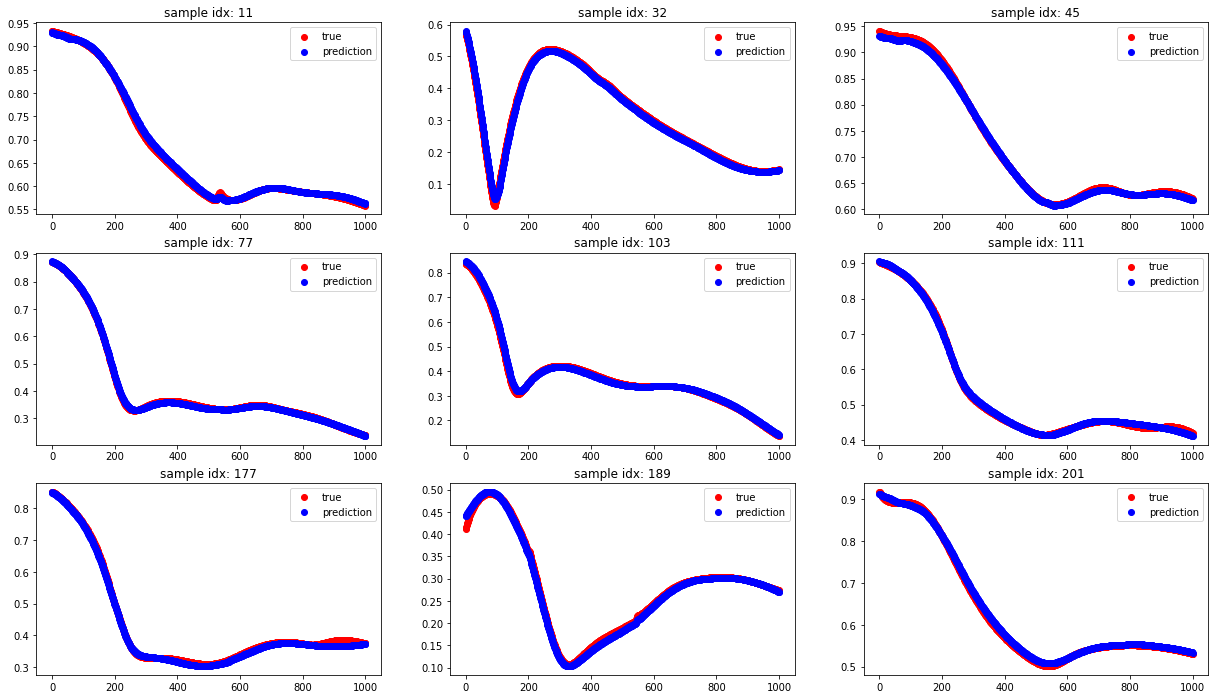

In [119]:
idx_test = [11,32,45,77,103,111,177,189,201]
print(tensor_x.shape)
print(tensor_y.shape)

X_test = tensor_x[idx_test,:]
y_test = tensor_y[idx_test,:]
print(X_test.shape)
print(y_test.shape)

X_test = X_test.to(device)
y_test_pred = net_dense(X_test)

y_test_np = y_test.cpu().detach().numpy()
y_test_pred_np = y_test_pred.cpu().detach().numpy()
print(y_test_np.shape)
print(y_test_pred_np.shape)


plt.figure(1, figsize=(21,12))
for idx_fig in range(9):
    plt.subplot(3, 3, idx_fig+1)
    plt.scatter(np.arange(1001), y_test_np[idx_fig,...], c='r')
    plt.scatter(np.arange(1001), y_test_pred_np[idx_fig,...], c='b')
    plt.legend(('true', 'prediction'))
    plt.title('sample idx: '+str(idx_test[idx_fig]))

## Interactive Demonstrative

In [124]:
#@markdown Slide the bar to adjust the variable and generate spectra

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

print('*****************************************')
print('ONLY change the variable labeled [V]')
print('*****************************************')

# add_spa=0.5; d=0.04; fillet=0; p=0.17; phi=0; px=0.7794; py=0.45; t_ground=0.1; t_pattern=0.03; t_spacer=0.02; theta=0
def fresh_visual(add_spa=0.5, d=0.04, fillet=0, p=0.17, phi=0, px=0.7794, py=0.45, t_ground=0.1, t_pattern=0.03, t_spacer=0.02, theta=0):
    X = torch.Tensor(np.array([[add_spa, d, fillet, p, phi, px, py, t_ground, t_pattern, t_spacer, theta]])).to(device)
    print(X)
    y_pred = net_dense(X)
    y_pred_np = y_pred.cpu().detach().numpy()

    plt.figure(1, figsize=(15,5))
    plt.scatter(np.arange(1001), y_pred_np, c='b')


style = {'description_width': 'initial'}
format = '.5f'

interact(fresh_visual, 
        add_spa = widgets.FloatSlider(value=0.5, min=0.00, max=1, step=0.01, description="add_spa", style=style, readout_format=format),
        d = widgets.FloatSlider(value=0.04, min=0.00, max=0.2, step=0.001, description="d [V]", style=style, readout_format=format),  # Var
        fillet = widgets.FloatSlider(value=0.0, min=0.00, max=1, step=0.01, description="fillet", style=style, readout_format=format),
        p = widgets.FloatSlider(value=0.17, min=0.00, max=1, step=0.01, description="p [V]", style=style, readout_format=format),  # Var
        phi = widgets.FloatSlider(value=0.0, min=0.00, max=1, step=0.01, description="phi", style=style, readout_format=format),
        px = widgets.FloatSlider(value=0.7794, min=0.00, max=1, step=0.01, description="px", style=style, readout_format=format),
        py = widgets.FloatSlider(value=0.45, min=0.00, max=1, step=0.01, description="py", style=style, readout_format=format),
        t_ground = widgets.FloatSlider(value=0.1, min=0.00, max=1, step=0.01, description="t_ground", style=style, readout_format=format),
        t_pattern = widgets.FloatSlider(value=0.03, min=0.00, max=1, step=0.01, description="t_pattern [V]", style=style, readout_format=format),  # Var
        t_spacer = widgets.FloatSlider(value=0.02, min=0.00, max=1, step=0.01, description="t_spacer", style=style, readout_format=format),
        theta = widgets.FloatSlider(value=0.0, min=0.00, max=1, step=0.01, description="theta", style=style, readout_format=format)
         )

*****************************************
ONLY change the variable labeled [V]
*****************************************


interactive(children=(FloatSlider(value=0.5, description='add_spa', max=1.0, readout_format='.5f', step=0.01, …

<function __main__.fresh_visual>

## Test on a Speerate Test Set

### Create Test Dataset

In [120]:
path_dataset_test = '/content/drive/My Drive/BU Class/Research/BioDL_Project/data/diatom_test.npz'

data_test = np.load(path_dataset_test)

param_test = data_test['param']
spectra_R_test = data_test['R'][...,1]
spectra_T_test = data_test['T'][...,1]

print(param_test.shape)
print(spectra_R_test.shape)
print(spectra_T_test.shape)

(40, 11)
(40, 1001)
(40, 1001)


In [121]:
tensor_x_test = torch.Tensor(param_test) # transform to torch tensor
tensor_y_test = torch.Tensor(spectra_R_test)

print(tensor_x_test.shape)
print(tensor_y_test.shape)

dataset_ref_test = TensorDataset(tensor_x_test,tensor_y_test)

dataloader_ref_test = DataLoader(dataset_ref_test, batch_size=10, shuffle=True)
print(len(dataloader_ref_test))

torch.Size([40, 11])
torch.Size([40, 1001])
4


### Run Model on Testset

torch.Size([40, 11])
torch.Size([40, 1001])
(40, 1001)
(40, 1001)
1 [0.5    0.045  0.     0.17   0.     0.7794 0.45   0.1    0.03   0.02
 0.    ]
2 [0.5    0.065  0.     0.17   0.     0.7794 0.45   0.1    0.03   0.02
 0.    ]
3 [0.5    0.085  0.     0.17   0.     0.7794 0.45   0.1    0.03   0.02
 0.    ]
4 [0.5    0.105  0.     0.17   0.     0.7794 0.45   0.1    0.03   0.02
 0.    ]
5 [0.5    0.125  0.     0.17   0.     0.7794 0.45   0.1    0.03   0.02
 0.    ]
6 [0.5    0.08   0.     0.17   0.     0.7794 0.45   0.1    0.04   0.02
 0.    ]
7 [0.5    0.08   0.     0.17   0.     0.7794 0.45   0.1    0.06   0.02
 0.    ]
8 [0.5    0.08   0.     0.17   0.     0.7794 0.45   0.1    0.08   0.02
 0.    ]
9 [0.5    0.06   0.     0.085  0.     0.7794 0.45   0.1    0.05   0.02
 0.    ]
10 [0.5    0.06   0.     0.105  0.     0.7794 0.45   0.1    0.05   0.02
 0.    ]
11 [0.5    0.06   0.     0.125  0.     0.7794 0.45   0.1    0.05   0.02
 0.    ]
12 [0.5    0.06   0.     0.145  0.     0.7794 0.45  

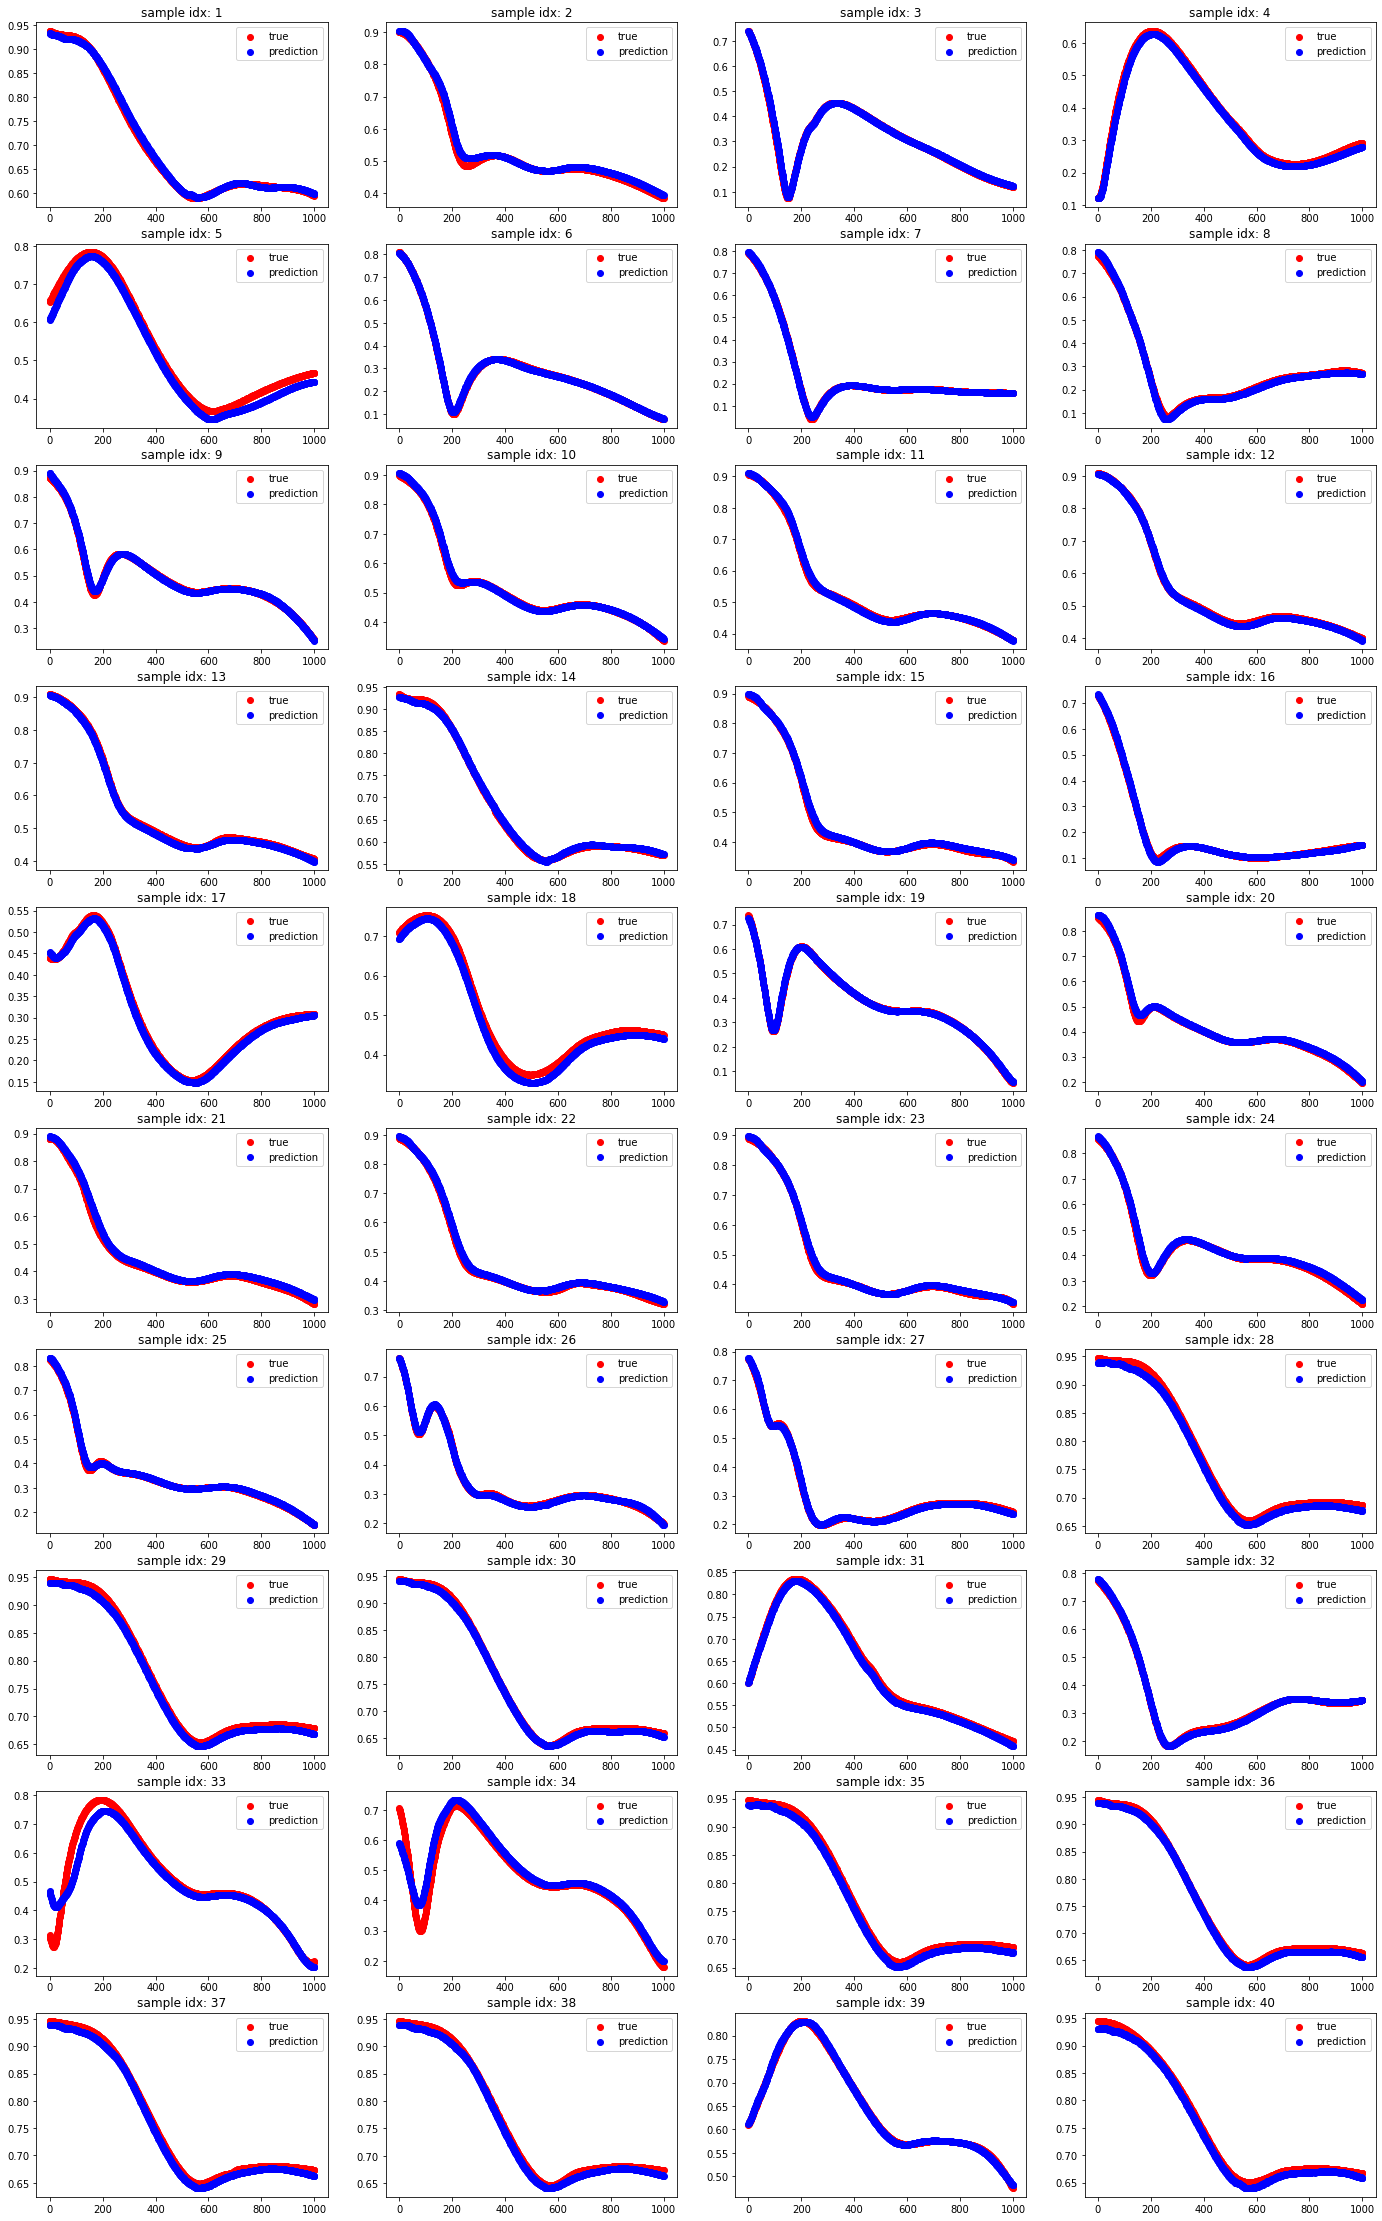

In [122]:
idx_test = range(40)

X_test = tensor_x_test[idx_test,:]
y_test = tensor_y_test[idx_test,:]
print(X_test.shape)
print(y_test.shape)

X_test = X_test.to(device)
y_test_pred = net_dense(X_test)

y_test_np = y_test.cpu().detach().numpy()
y_test_pred_np = y_test_pred.cpu().detach().numpy()
print(y_test_np.shape)
print(y_test_pred_np.shape)


plt.figure(1, figsize=(24,40))
for idx_fig in range(40):
    plt.subplot(10, 4, idx_fig+1)
    plt.scatter(np.arange(1001), y_test_np[idx_fig,...], c='r')
    plt.scatter(np.arange(1001), y_test_pred_np[idx_fig,...], c='b')
    plt.legend(('true', 'prediction'))
    plt.title('sample idx: '+str(idx_test[idx_fig]+1))

    print(idx_fig+1, X_test[idx_fig,...].cpu().detach().numpy())

# Visualize Results

torch.Size([219, 11])
torch.Size([219, 1001])
torch.Size([1, 11])
torch.Size([1, 1001])
DESIGN PARAMS tensor([[0.5000, 0.0600, 0.0000, 0.1600, 0.0000, 0.7794, 0.4500, 0.1000, 0.0300,
         0.0200, 0.0000]], device='cuda:0')
[[0.9178519  0.91807425 0.918538   ... 0.4556108  0.45506757 0.454706  ]]


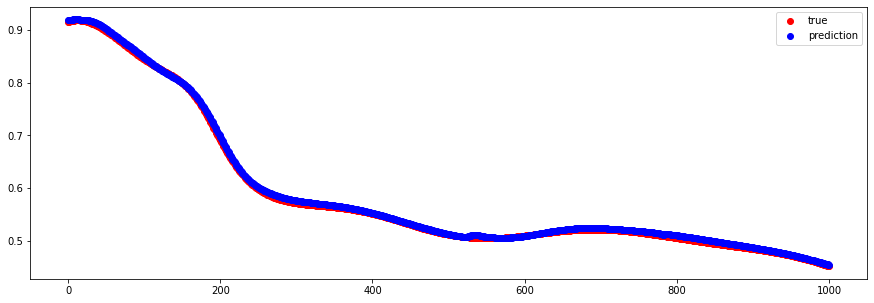

In [ ]:
idx_test = 12
print(tensor_x.shape)
print(tensor_y.shape)

X_test = tensor_x[idx_test,:].unsqueeze(0)
y_test = tensor_y[idx_test,:].unsqueeze(0)

print(X_test.shape)
print(y_test.shape)

X_test = X_test.to(device)
y_test_pred = net_dense(X_test)
print('DESIGN PARAMS', X_test)

y_test_np = y_test.cpu().detach().numpy()
y_test_pred_np = y_test_pred.cpu().detach().numpy()
print(y_test_pred_np)

# plt.figure(1)
# plt.plot(np.arange(1001), y_test_np)
# plt.figure(2)
# plt.plot(np.arange(1001), y_test_pred_np)

plt.figure(3, figsize=(15,5))
plt.scatter(np.arange(1001), y_test_np, c='r')
plt.scatter(np.arange(1001), y_test_pred_np, c='b')
plt.legend(('true', 'prediction'))

torch.Size([219, 11])
torch.Size([219, 1001])
torch.Size([1, 11])
torch.Size([1, 1001])
DESIGN PARAMS tensor([[0.5000, 0.0800, 0.0000, 0.1600, 0.0000, 0.7794, 0.4500, 0.1000, 0.0700,
         0.0200, 0.0000]], device='cuda:0')
[[0.78385854 0.78313327 0.78231156 ... 0.21357903 0.21338844 0.21344484]]


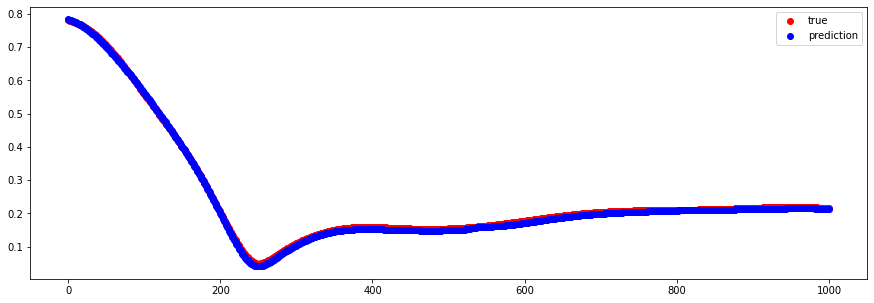

In [ ]:
idx_test = 123
print(tensor_x.shape)
print(tensor_y.shape)

X_test = tensor_x[idx_test,:].unsqueeze(0)
y_test = tensor_y[idx_test,:].unsqueeze(0)

print(X_test.shape)
print(y_test.shape)

X_test = X_test.to(device)
y_test_pred = net_dense(X_test)
print('DESIGN PARAMS', X_test)

y_test_np = y_test.cpu().detach().numpy()
y_test_pred_np = y_test_pred.cpu().detach().numpy()
print(y_test_pred_np)

# plt.figure(1)
# plt.plot(np.arange(1001), y_test_np)
# plt.figure(2)
# plt.plot(np.arange(1001), y_test_pred_np)

plt.figure(3, figsize=(15,5))
plt.scatter(np.arange(1001), y_test_np, c='r')
plt.scatter(np.arange(1001), y_test_pred_np, c='b')
plt.legend(('true', 'prediction'))